In [1]:
# basic imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# sklearn
# preprocessing, model selection and metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

# models
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

# visualize importances
import shap

pd.set_option('max_columns', None)
plt.style.use('ggplot')

In [2]:
from datetime import date
import gc

In [3]:
my_data = './data/'
fat_ljs_atual = pd.read_csv(my_data + 'faturamento_lojas_atuais.csv')
cen_exp = pd.read_csv(my_data + 'cenarios_expansao.csv')
ljs_atual = pd.read_csv(my_data + 'lojas_atuais.csv')

In [4]:
merge = fat_ljs_atual.merge(ljs_atual, on='cod_loja')

In [5]:
merge

,cod_loja,ano,mes,categoria,qtde,receita,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18
0,1,2016,1,CATEG_01,301.0,9164.86,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2016,2,CATEG_01,187.0,8175.55,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2016,3,CATEG_01,242.0,10521.67,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2016,4,CATEG_01,104.0,4560.91,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2016,5,CATEG_01,100.0,4263.30,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,0.167659,115.958848,2.349821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003089,3687,2017,8,CATEG_14,334.0,634.60,4211702001001,4211702,NaN,FEATURE_02_VALUE_04,False,26.50,FEATURE_05_VALUE_03,2,0.199854,0.193531,7.701540,4.454541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003090,3687,2017,9,CATEG_14,33.0,62.70,4211702001001,4211702,NaN,FEATURE_02_VALUE_04,False,26.50,FEATURE_05_VALUE_03,2,0.199854,0.193531,7.701540,4.454541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003091,3687,2017,10,CATEG_14,184.0,349.60,4211702001001,4211702,NaN,FEATURE_02_VALUE_04,False,26.50,FEATURE_05_VALUE_03,2,0.199854,0.193531,7.701540,4.454541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003092,3687,2017,11,CATEG_14,28.0,61.30,4211702001001,4211702,NaN,FEATURE_02_VALUE_04,False,26.50,FEATURE_05_VALUE_03,2,0.199854,0.193531,7.701540,4.454541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
mun_list = cen_exp.cod_municipio.unique()

In [123]:
###### cen_exp.head()
mun = mun_list[55]

fat_mun = merge[merge.cod_municipio == mun]
feats = ['feature_03', 'feature_04', 'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18']
group16 = fat_mun[fat_mun.ano == 2016].groupby(['cod_loja', 'cod_municipio', 'mes', 'ano', 'cod_ap'] + feats, as_index=False).sum()
group17 = fat_mun[fat_mun.ano == 2017].groupby(['cod_loja', 'cod_municipio', 'mes', 'ano', 'cod_ap'] + feats, as_index=False).sum()
mensal = group16.append(group17)
mensal['datetime'] = pd.to_datetime(mensal.ano*100+mensal.mes,format='%Y%m')
mensal

,cod_loja,cod_municipio,mes,ano,cod_ap,feature_03,feature_04,feature_06,feature_07,feature_08,feature_09,feature_10,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,qtde,receita,datetime
0,1515,3201209,1,2016,3201209003004,True,36.0,2,0.157431,0.132164,87.883825,2.39576,100.0,89.2,100.0,100.0,69.1,86.9,2407.0,98637.44,2016-01-01
1,1515,3201209,2,2016,3201209003004,True,36.0,2,0.157431,0.132164,87.883825,2.39576,100.0,89.2,100.0,100.0,69.1,86.9,1769.0,75543.38,2016-02-01
2,1515,3201209,3,2016,3201209003004,True,36.0,2,0.157431,0.132164,87.883825,2.39576,100.0,89.2,100.0,100.0,69.1,86.9,2235.0,105955.64,2016-03-01
3,1515,3201209,4,2016,3201209003004,True,36.0,2,0.157431,0.132164,87.883825,2.39576,100.0,89.2,100.0,100.0,69.1,86.9,2277.0,113134.34,2016-04-01
4,1515,3201209,5,2016,3201209003004,True,36.0,2,0.157431,0.132164,87.883825,2.39576,100.0,89.2,100.0,100.0,69.1,86.9,3157.0,152291.89,2016-05-01
5,1515,3201209,6,2016,3201209003004,True,36.0,2,0.157431,0.132164,87.883825,2.39576,100.0,89.2,100.0,100.0,69.1,86.9,2668.0,121826.63,2016-06-01
6,1515,3201209,7,2016,3201209003004,True,36.0,2,0.157431,0.132164,87.883825,2.39576,100.0,89.2,100.0,100.0,69.1,86.9,1922.0,99169.12,2016-07-01
7,1515,3201209,8,2016,3201209003004,True,36.0,2,0.157431,0.132164,87.883825,2.39576,100.0,89.2,100.0,100.0,69.1,86.9,2165.0,118470.86,2016-08-01
8,1515,3201209,9,2016,3201209003004,True,36.0,2,0.157431,0.132164,87.883825,2.39576,100.0,89.2,100.0,100.0,69.1,86.9,1873.0,98766.13,2016-09-01
9,1515,3201209,10,2016,3201209003004,True,36.0,2,0.157431,0.132164,87.883825,2.39576,100.0,89.2,100.0,100.0,69.1,86.9,2038.0,96855.34,2016-10-01


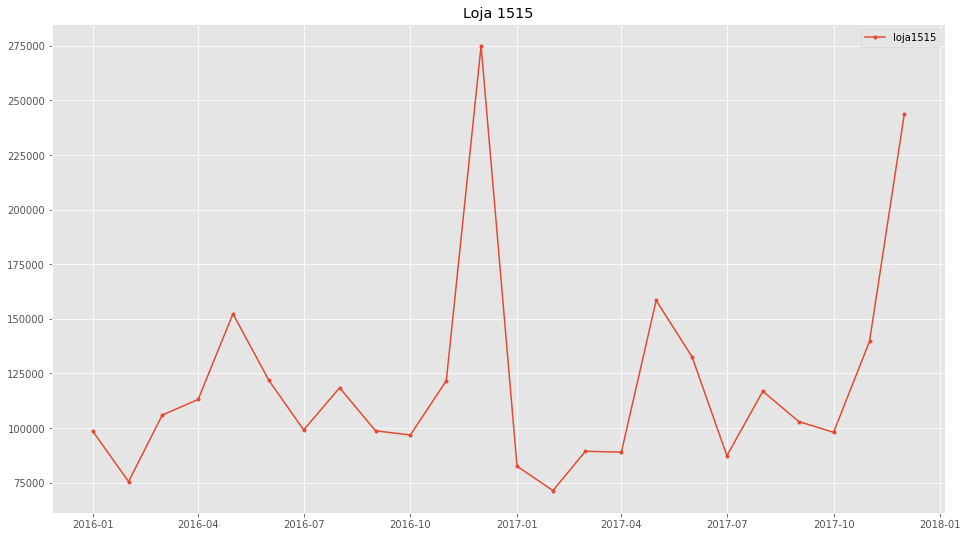

In [124]:
plt.figure(figsize=(16,9))
for cod in mensal.cod_loja.unique()[:]:
    loj_mensal = mensal[mensal.cod_loja == cod]
    plt.title("Loja {}".format(cod))
    plt.plot(loj_mensal["datetime"], loj_mensal["receita"], label='loja' + str(cod), marker=".")
    plt.legend()
plt.show()

In [9]:
cen_exp[cen_exp.cod_loja == 28]

,cod_loja,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18
4,28,3550308005058,3550308,FEATURE_01_VALUE_10,FEATURE_02_VALUE_02,True,44.31,FEATURE_05_VALUE_03,8,0.190102,0.17914,5593.905463,2.815883,FEATURE_11_VALUE_02,FEATURE_12_VALUE_01,NaN,NaN,NaN,NaN,NaN,NaN


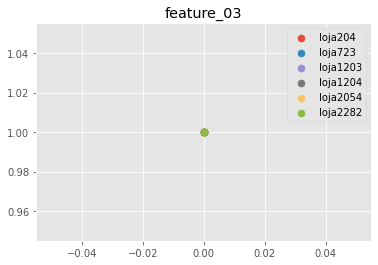

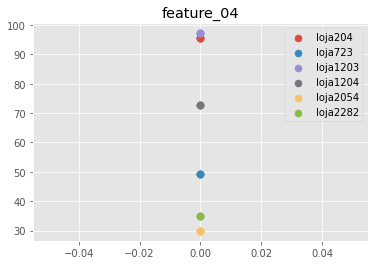

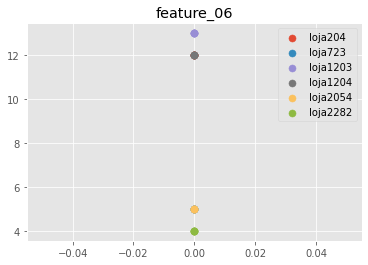

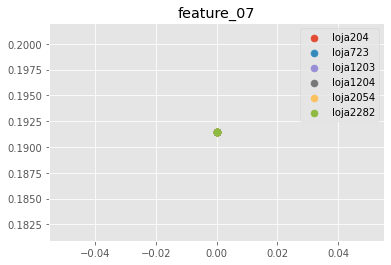

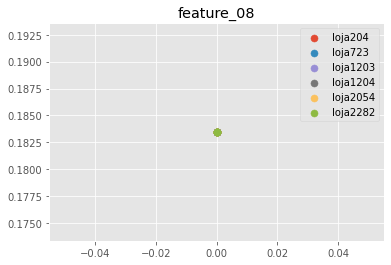

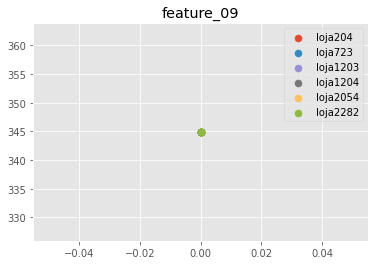

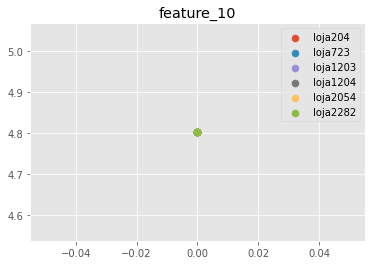

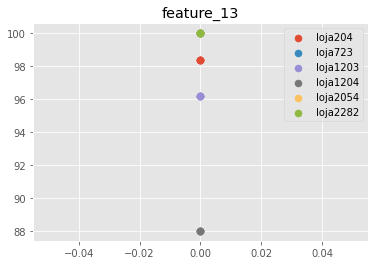

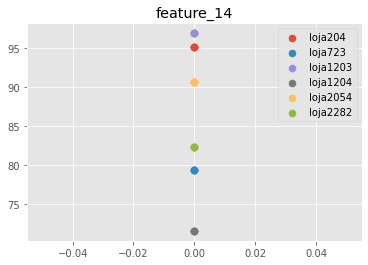

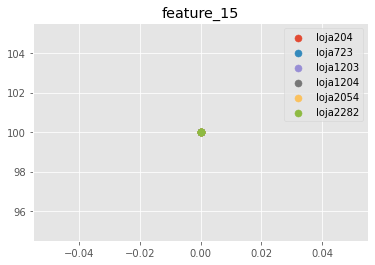

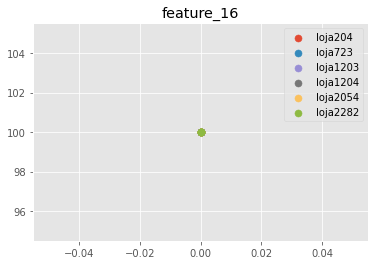

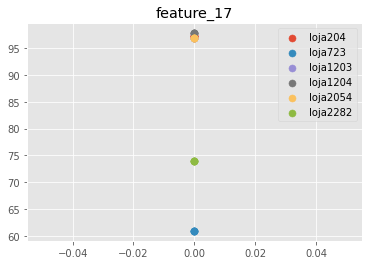

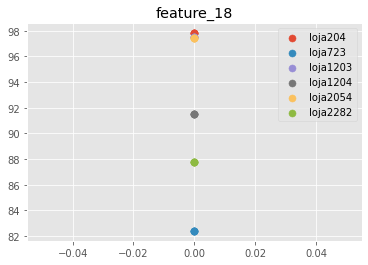

In [88]:
lojas_feats = mensal.groupby(['cod_loja'] + feats, as_index=False).sum()[['cod_loja'] + feats]
for feat in feats:
    for cod in mensal.cod_loja.unique()[:]:
        loj_mensal = mensal[mensal.cod_loja == cod]
        plt.scatter([0,0,0,0,0], loj_mensal[feat][:5], label='loja' + str(cod), marker=".", s=200, vmin=-1, vmax=1)
        plt.legend()
    plt.title(feat)
    plt.show()


In [32]:
feats[8:10]

['feature_14', 'feature_15']

In [35]:
ljs_atual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3130 entries, 0 to 3129
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cod_loja       3130 non-null   int64  
 1   cod_ap         3130 non-null   int64  
 2   cod_municipio  3130 non-null   int64  
 3   feature_01     1171 non-null   object 
 4   feature_02     3130 non-null   object 
 5   feature_03     3130 non-null   bool   
 6   feature_04     3130 non-null   float64
 7   feature_05     3130 non-null   object 
 8   feature_06     3130 non-null   int64  
 9   feature_07     3130 non-null   float64
 10  feature_08     3130 non-null   float64
 11  feature_09     3130 non-null   float64
 12  feature_10     3130 non-null   float64
 13  feature_11     245 non-null    object 
 14  feature_12     245 non-null    object 
 15  feature_13     874 non-null    float64
 16  feature_14     874 non-null    float64
 17  feature_15     874 non-null    float64
 18  feature_